In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta

In [2]:
# =========================
# Load datasets
# =========================
PATIENTS = pd.read_csv("PATIENTS.csv")
ADMISSIONS = pd.read_csv("ADMISSIONS.csv")
DIAGNOSES = pd.read_csv("DIAGNOSES_ICD.csv")
ICU = pd.read_csv("ICUSTAYS.csv")
PRESCRIPTIONS = pd.read_csv("PRESCRIPTIONS.csv")

In [3]:
# =========================
# Data Preprocessing
# =========================
# Convert date columns to datetime format
for col in ['DOB', 'DOD']:
    PATIENTS[col] = pd.to_datetime(PATIENTS[col], errors='coerce')
ADMISSIONS['ADMITTIME'] = pd.to_datetime(ADMISSIONS['ADMITTIME'], errors='coerce')
ICU['INTIME'] = pd.to_datetime(ICU['INTIME'], errors='coerce')
ICU['OUTTIME'] = pd.to_datetime(ICU['OUTTIME'], errors='coerce')

# Handle missing or invalid dates
REFERENCE_DATE = pd.to_datetime('2100-01-01')
PATIENTS.loc[PATIENTS['DOD'].isna(), 'DOD'] = REFERENCE_DATE
PATIENTS = PATIENTS.dropna(subset=['DOB'])
PATIENTS = PATIENTS[PATIENTS['DOB'] < REFERENCE_DATE]

# Compute age
PATIENTS['AGE'] = PATIENTS.apply(lambda row: relativedelta(row['DOD'], row['DOB']).years, axis=1)
PATIENTS = PATIENTS[(PATIENTS['AGE'] > 0) & (PATIENTS['AGE'] < 120)]

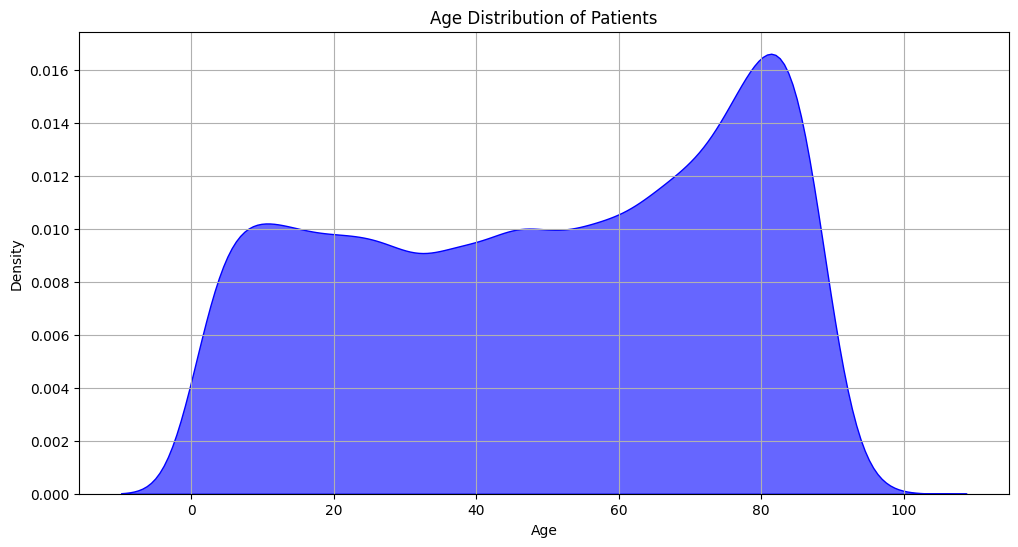

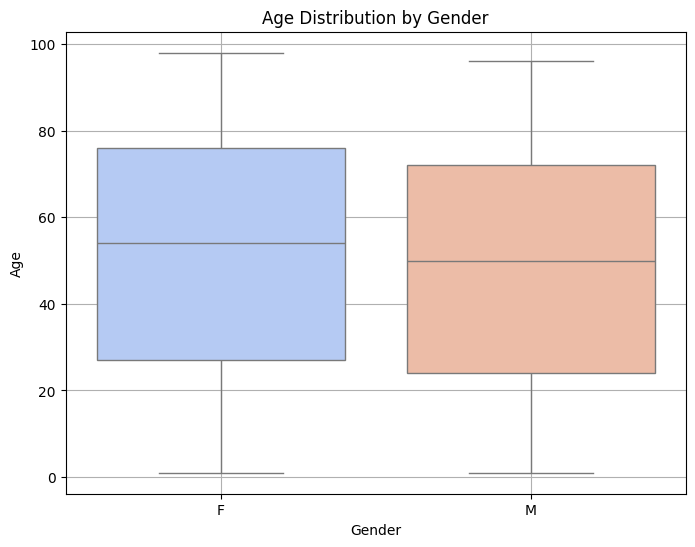

In [11]:
# =========================
# 1. Age Distribution of Patients
# =========================
plt.figure(figsize=(12, 6))
sns.kdeplot(PATIENTS['AGE'], fill=True, color='blue', alpha=0.6)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='GENDER', y='AGE', data=PATIENTS, hue='GENDER', palette='coolwarm')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.grid(True)
plt.show()

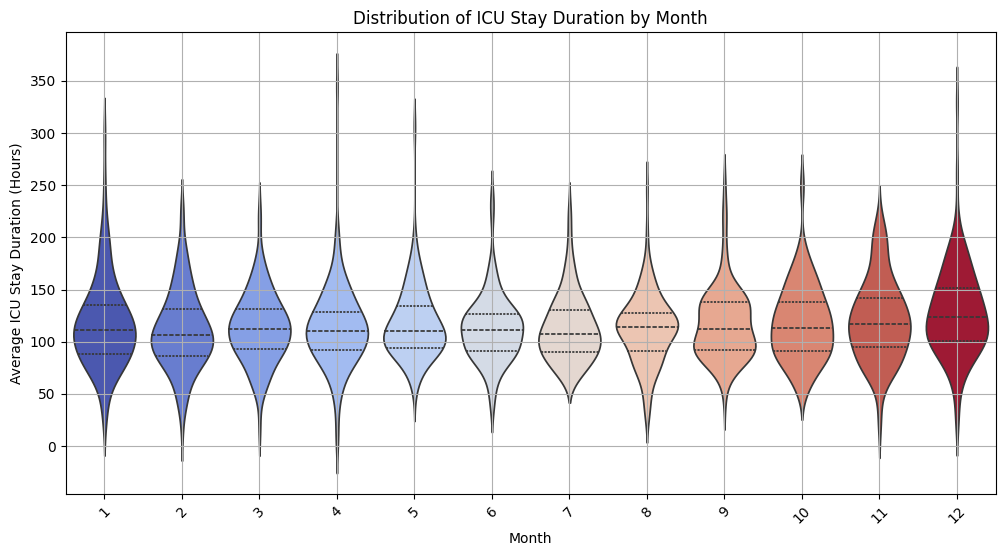

In [5]:
# =========================
# 2. ICU Admissions Over Time
# =========================
ICU['DURATION_HOURS'] = (ICU['OUTTIME'] - ICU['INTIME']).dt.total_seconds() / 3600
ICU_ADMISSIONS = ICU.set_index('INTIME').resample('ME')['DURATION_HOURS'].mean()
plt.figure(figsize=(12, 6))
sns.violinplot(x=ICU_ADMISSIONS.index.month, y=ICU_ADMISSIONS.values, hue=ICU_ADMISSIONS.index.month, palette='coolwarm', inner='quartile', legend=False)
plt.title('Distribution of ICU Stay Duration by Month')
plt.xlabel('Month')
plt.ylabel('Average ICU Stay Duration (Hours)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

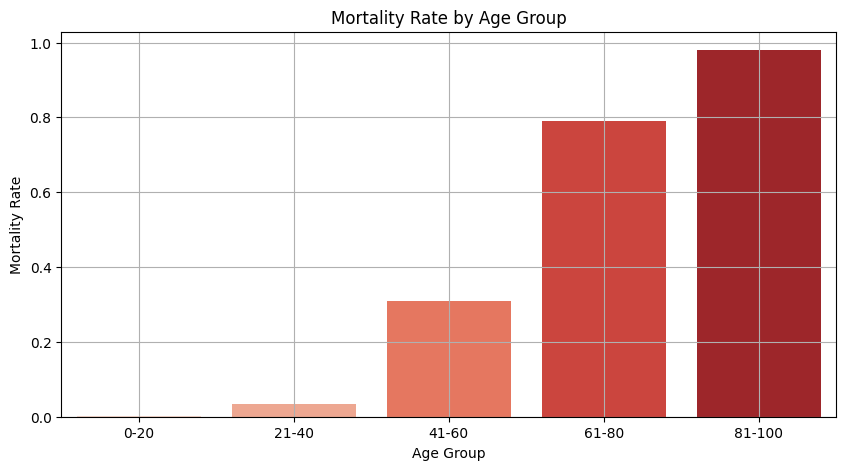

In [10]:
# =========================
# 3. Mortality Rate by Age Group
# =========================
AGE_BINS = [0, 20, 40, 60, 80, 100]
AGE_LABELS = ['0-20', '21-40', '41-60', '61-80', '81-100']
PATIENTS['AGE_GROUP'] = pd.cut(PATIENTS['AGE'], bins=AGE_BINS, labels=AGE_LABELS, include_lowest=True, right=False)
MORTALITY_RATE = PATIENTS.groupby('AGE_GROUP', observed=False)['EXPIRE_FLAG'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=MORTALITY_RATE.index, y=MORTALITY_RATE.values, hue=MORTALITY_RATE.index, palette='Reds', legend=False)
plt.title('Mortality Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mortality Rate')
plt.grid(True)
plt.show()

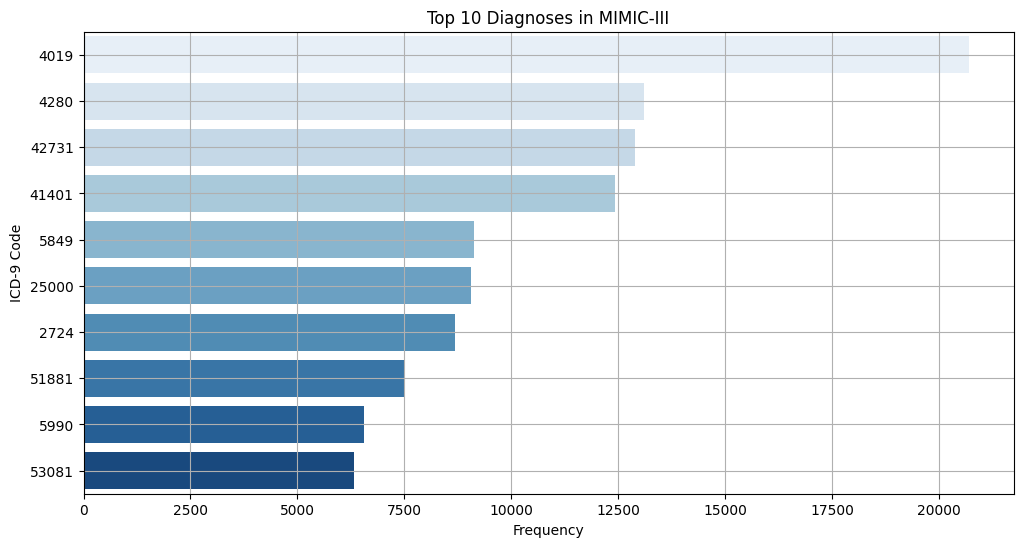

In [7]:
# =========================
# 4. Common Diagnoses Among Patients
# =========================
DIAGNOSES_COUNT = DIAGNOSES['ICD9_CODE'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=DIAGNOSES_COUNT.values, y=DIAGNOSES_COUNT.index, hue=DIAGNOSES_COUNT.index, palette='Blues', legend=False)
plt.title('Top 10 Diagnoses in MIMIC-III')
plt.xlabel('Frequency')
plt.ylabel('ICD-9 Code')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

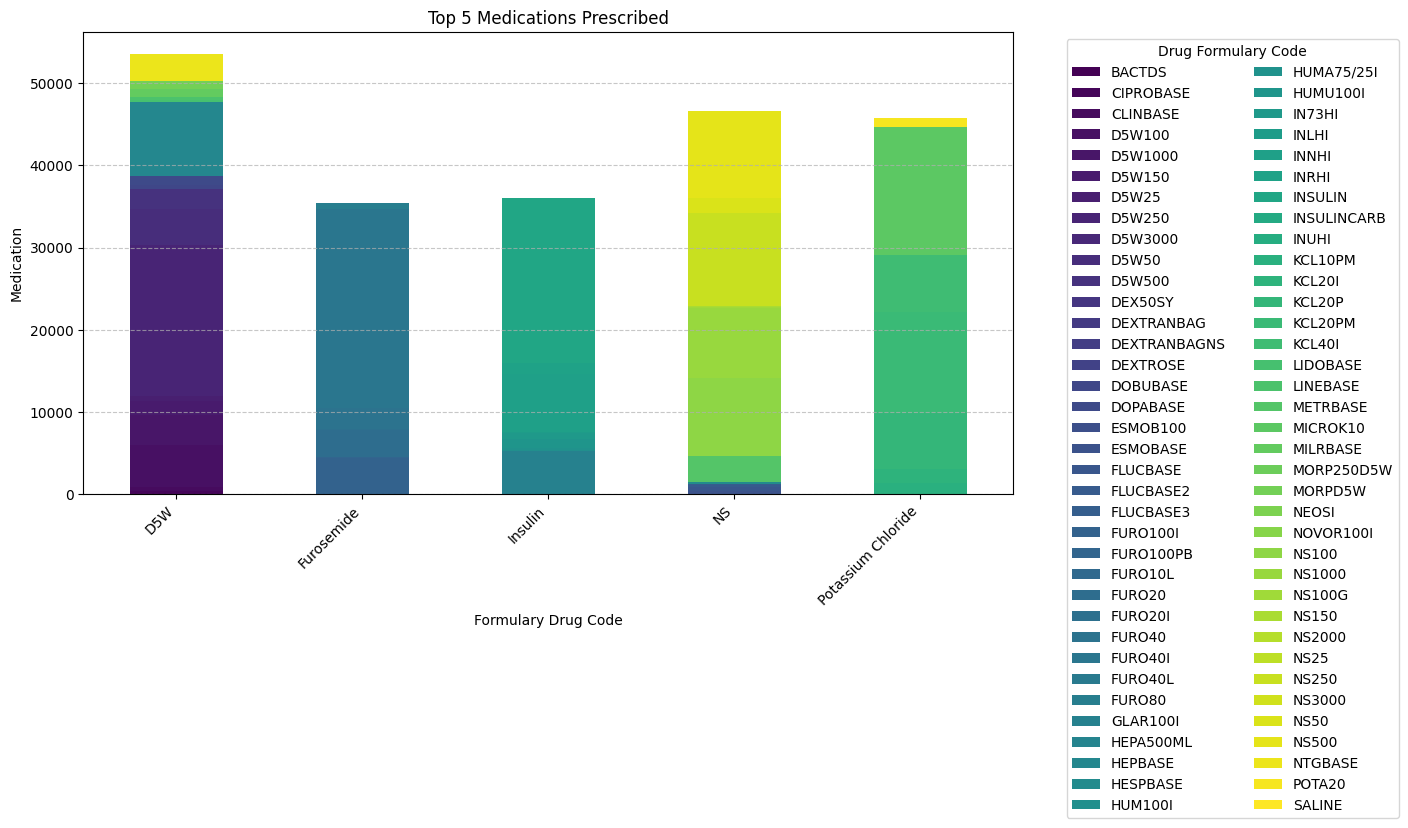

In [8]:
# =========================
# 5. Medication Prescriptions by Drug Type
# =========================
TOP_MEDS = PRESCRIPTIONS['DRUG'].value_counts().head(5).index
MED_COUNTS = PRESCRIPTIONS[PRESCRIPTIONS['DRUG'].isin(TOP_MEDS)].groupby(['DRUG', 'FORMULARY_DRUG_CD']).size().unstack()

plt.figure(figsize=(12, 6))
ax = MED_COUNTS.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.xticks(rotation=45, ha='right')
plt.legend(title='Drug Formulary Code', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Top 5 Medications Prescribed')
plt.xlabel('Formulary Drug Code')
plt.ylabel('Medication')
plt.show()